# 스타벅스 고객 리뷰 감성 분석 



In [6]:
# 데이터셋
# 스타벅스 고객 리뷰 - 카카오맵

In [336]:
import pandas as pd
import numpy as np

import kss
from tqdm import tqdm
from kss import split_sentences
from konlpy.tag import Komoran

import warnings
warnings.simplefilter("ignore")

In [404]:
path = 'C:/playdata/Deep-Learning_basic/dataset/starbuck review/'
review_df = pd.read_csv(path+'train.csv')
test_df = pd.read_csv(path+'test.csv', encoding='cp949', index_col = 0)
review_df

,label,document
0,0,주말에 사람이 적은 편. 2층 와이파이가 안돼서 1층 와이파이에 연결했는데 불안정함.
1,1,파트너분들 진짜 세상 친절하시고 너무 좋아요ㅎ
2,1,방금 확인했어요~
3,0,별적립 12개 무료음료쿠폰으로는 프리퀀시적립이 안된다기에 (작년에는 됐던것같아서) ...
4,1,요 근처에서 보기드물게 넓고 쾌적한 스벅이네요~
...,...,...
3792,1,직원분들 친절했어요
3793,1,너무 맘에드네요. 주차도 가능하구요~
3794,0,"계산하는 나이 있어보이는 여자, 자기 잘못을 고객에게 전가하려 하고 싸가지 없음! ..."
3795,1,확트인공간 맛난커피 그런데 주차가 ㅠㅠ딱지끊은적잇음료 길가주차하지마세요


In [405]:
# 제출 데이터 index 수정
test_df['no.'] = [_ for _ in range(1266)]
test_df.set_index('no.', inplace = True)
test_df

,document
no.,
0,화장실이 좀 별로지만 직원분들 다 친절하시고 매장 깔끔함
1,최고예요
2,서비스 굿
3,"친절하고, 자리 넓고 좋아요"
4,최고예요
...,...
1261,드라이브쓰루 좋아요
1262,사이렌오더 확인안함.. 직원 5명 아무것도 안하고 수다떨고.. 매장와서 사이렌오더...
1263,스타벅스는 직원교육으로 유명한데.. 여기 스탭님들은 왜....


### 데이터 전처리

In [406]:
def remove_special_letter(series) :
    import re
    for i in range(len(series)) :
        series[i] = re.split('[.!?()~*"ㅋ\n]', series[i])
    
    for i in range(len(series)) :
        num = ''
        for j in range(len(series[i]))  :
             num += series[i][j]
        series[i] = num
    return series

In [407]:
def replace_special_letter(series) :
    for i in range(len(series)) :
        series[i] = series[i].replace('^^', ' 좋음')
        series[i] = series[i].replace('ㅠ', ' 슬픔 아쉬움')
        series[i] = series[i].replace('♥', ' 좋음')
        series[i] = series[i].replace('♡', ' 좋음')
        series[i] = series[i].replace('★', ' 좋음')
        series[i] = series[i].replace(';', ' 아쉬움')
        series[i] = series[i].replace('ㅎㅎ', ' 좋음')
        series[i] = series[i].replace('ㅎ', ' 좋음 당황')
        
    for i in range(len(series)) :
        num = ''
        for j in range(len(series[i]))  :
             num += series[i][j]
        series[i] = num
    return series

In [340]:
# 학습 데이터 전처리
review_df['document'] = remove_special_letter(review_df['document'])
review_df['document'] = replace_special_letter(review_df['document'])

processed_df = review_df['document']
processed_df

0           주말에 사람이 적은 편 2층 와이파이가 안돼서 1층 와이파이에 연결했는데 불안정함
1                          파트너분들 진짜 세상 친절하시고 너무 좋아요 좋음 당황
2                                                방금 확인했어요
3       별적립 12개 무료음료쿠폰으로는 프리퀀시적립이 안된다기에 작년에는 됐던것같아서 아 ...
4                               요 근처에서 보기드물게 넓고 쾌적한 스벅이네요
                              ...                        
3792                                           직원분들 친절했어요
3793                                   너무 맘에드네요 주차도 가능하구요
3794    계산하는 나이 있어보이는 여자, 자기 잘못을 고객에게 전가하려 하고 싸가지 없음 다...
3795    확트인공간 맛난커피 그런데 주차가  슬픔 아쉬움 슬픔 아쉬움딱지끊은적잇음료 길가주차...
3796                                    넓고 좌석 많아요 사람도 많지만
Name: document, Length: 3797, dtype: object

In [409]:
# 제출 데이터 전처리
test_df['document'] = remove_special_letter(test_df['document'])
test_df['document'] = replace_special_letter(test_df['document'])
processed_test_df = test_df['document']
processed_test_df

no.
0                         화장실이 좀 별로지만 직원분들 다 친절하시고 매장 깔끔함
1                                                    최고예요
2                                                   서비스 굿
3                                         친절하고, 자리 넓고 좋아요
4                                                    최고예요
                              ...                        
1261                                           드라이브쓰루 좋아요
1262    사이렌오더 확인안함  직원 5명 아무것도 안하고 수다떨고 매장와서 사이렌오더 했다고...
1263                         스타벅스는 직원교육으로 유명한데 여기 스탭님들은 왜
1264                                              조금 아쉬워요
1265                               친절하시고 장소도 3층까지 넓고 아늑해요
Name: document, Length: 1266, dtype: object

### 품사 필터링 및 텍스트 정제

In [238]:
print('참고 : https://wikidocs.net/33799')

참고 : https://wikidocs.net/33799


In [341]:
import konlpy
from konlpy.tag import *
okt = Okt()
hannanum = Hannanum()
kkma = Kkma()
komoran = Komoran()

In [342]:
okt.pos(processed_df[1])

[('파트너', 'Noun'),
 ('분들', 'Suffix'),
 ('진짜', 'Noun'),
 ('세상', 'Noun'),
 ('친절하시고', 'Adjective'),
 ('너무', 'Adverb'),
 ('좋아요', 'Adjective'),
 ('좋음', 'Adjective'),
 ('당황', 'Noun')]

okt 체크사항
- norm옵션 : 그래욬ㅋㅋ -> 그래요 처럼 변환해주는 옵션
- stem옵션 : 원형을 찾아주는 옵션 (그래요 -> 그렇다)

In [410]:
# 데이터 정제
def text_refine(series) : 
    for idx, content in enumerate(series) :
        clean_words = []
        for word in okt.pos(content, norm = True, stem = True) : 
            if word[1] in ['Noun', 'Verb', 'Adjective', 'Adverb']: #명사, 동사, 형용사, 부사
                clean_words.append(word[0])
        print(clean_words) #['파트너', '진짜', '세상', '친절하시고', ...]
        content = ' '.join(clean_words)  # 파트너 진짜 세상 친절
        series[idx] = content
    # 피쳐 데이터 (2차원으로 변경)
    return pd.DataFrame(series)

In [411]:
processed_filtering_training_df = text_refine(processed_df)
processed_filtering_test_df =  text_refine(processed_test_df)

['주말', '사람', '적다', '편', '층', '와이파이', '돼다', '층', '와이파이', '연결하다', '불안정하다']
['파트너', '진짜', '세상', '친절하다', '너무', '좋다', '좋다', '당황']
['방금', '확인', '하다']
['적립', '개', '무료', '음료', '쿠폰', '프리', '퀀', '적립', '안되다', '작년', '돼다', '같다', '적립', '안되다', '하다', '물다', '무료', '쿠폰', '요', '말', '하다', '그', '뉘앙스', '마치', '공짜', '쿠폰', '적립', '바라냐', '그렇다', '느낌', '다르다', '답변', '해주다', '있다', '아니다', '좀', '불쾌하다']
['요', '근처', '보기', '드물다', '넓다', '쾌적하다', '스벅', '요']
['좋다']
['집', '가깝다', '좋다']
['카페모카', '맛남', '좋다']
[]
['저', '그닥', '여러가지', '별로']
['별로']
['좋다']
['유독', '이', '지점', '직원', '불친절하다']
[]
['최고']
['최고']
['별로', '다시', '안감']
['별로']
['최고']
['테이블', '정말', '얼마', '없다', '자리', '잡기', '운', '달리', '코로나', '땜', '거리', '두기', '하다', '거', '이해해', '오히려', '안', '하다', '곳', '많다', '거기', '익숙해지다', '나', '자신', '깨달음', '특히', '저녁', '바쁘다', '매장', '같다', '여유롭다', '자리', '잡고', '말다', '싶다', '땐', '비추다', '매장', '넓다', '않다', '직원', '친절하다', '음료', '맛있다']
['얼음', '다른', '스벅', '다르다', '같다', '진짜', '양', '그렇다', '적다', '더', '적다', '느낌']
['맨날', '시끄럽다', '복작', '거림']
['이렇게', '불친절하다', '네가지', '없다', '스타

['좋다']
['좋다']
['지금', '가다', '보다', '스타벅스', '중', '직원', '태도', '제일', '별로', '케이크', '주문', '하다', '하나', '나중', '가져가다', '싶다', '하다', '네', '하다', '결제', '하다', '나중', '안되다', '개', '다', '지금', '가져가다', '하다', '하다', '처음', '자다', '설명', '해주다', '상온', '두다', '되다', '거', '고', '하다', '유제품', '글쎄요', '하다', '오히려', '당황', '하다', '스타벅스', '이렇다', '경우', '있다', '여기', '이제', '가다']
['직원', '친절하다', '좋다', '와이파이', '너무', '자주', '끊기다', '슬픔', '아쉬움', '슬픔', '아쉬움']
['라떼', '달라', '그냥', '우유', '주다', '게']
['최고']
['깔끔하다', '직원', '친절하다']
['춥다']
['층', '넓다', '사용', '하다', '좋다']
['최고']
['최고']
['드라이브스루', '되다', '직원', '친절하다', '좋다']
['직원', '매우', '친절하다']
['넓다', '도심지', '좋다', '건물', '안이', '층', '창가', '지리', '항상', '사람', '있다']
['사람', '바글바글']
['조금', '아쉽다']
['파트너', '친절하다', '다', '좋다', '리뉴얼', '콘센트', '없애다', '버리다', '아예', '기', '책상', '콘센트', '있다', '화장실', '물', '비누', '항상', '없다', '거', '빼다', '만족']
['늘', '불친절']
['오전', '다녀오다', '직원', '친절하다', '좋다', '콜드', '폼', '콜드', '부르다', '먹다', '간만', '제대로', '되다', '스벅', '커피', '말다', '전', '여기', '추천', '하다']
['접근성', '용이', '지하철역', '버스정류장', '가깝다', '움', '와이파이'

['차이', '라떼', '시키다', '너무', '달다', '말다', '정도', '층', '일', '하다', '구', '하다', '시끄럽다', '사람', '너무', '많다', '스타벅스', '리다', '하다', '코드', '되다', '없다', '어이', '없다', '이미', '라떼', '사', '버리다', '그냥', '있다', '스타벅스', '역시', '오다', '아니다']
['직원', '친절하다']
['앞서', '단체', '주문', '받다', '더', '기다리다', '요', '커피한잔', '주문', '하다']
['최고']
['분위기', '좋다', '동네', '커피숍', '느낌', '타', '스벅', '넓다', '쾌적']
['최고']
['편하다', '좋다']
['근처', '스타벅스', '갈다', '함']
['좋다']
['최고']
['좋다']
['사람', '많다', '주차공간', '아무렇다', '주차', '되어다', '있다', '주차', '라인', '맞추다', '주차', '지도', '및', '차', '관리', '해주다']
['좋다']
['좋다']
['불친절']
['늘', '사람', '많다', '종업원', '친절']
['매장', '넓다', '커피', '맛', '괜찮다', '어디', '마찬가지', '점심', '시간', '북적', '북적', '정신', '없다']
['좋다']
['꽤', '자주', '오래', '가다', '곳', '붐비다', '시간대', '자리', '찾기', '어려움', '서비스', '시설', '만족하다']
['바쁘다', '직원', '힘들다', '보이', '친절하다', '뷰', '최고', '사람', '없다', '시간대', '오다', '정말', '좋다', '곳', '사람', '많다', '시간대', '오다', '층', '전체', '자리', '없다']
['최고']
['사람', '많다', '땐', '진짜', '대박', '많다', '덜', '붐비다', '시간대', '창가', '앉다', '너무', '좋다']
['여기', '스타벅스', '직원', '왜', '불친절하다'

['친절하다']
['그냥', '무난', '무난', '해']
['직원', '대박', '친절하다', '좋다']
['최고']
['최고']
['주차', '안되다', '바로', '옆', '건물', '주차', '무조건']
['이마트', '닫다', '날', '같이', '닫다']
['아쉽다', '콘센트', '다', '막히다', '유', '에스', '비', '충전', '가능하다', '같다']
['가격', '이제', '비싸다', '않다', '매장', '크다', '죽순', '없다', '자리', '항상', '많다', '외국', '기업', '빼다', '다', '마음', '다']
['포장', '되다', '매장', '음식', '먹다', '문제', '있다', '매니저', '센스', '있다', '대처', '자다', '하다']
['오늘', '리저', '브', '매장', '재', '오픈', '하다']
['네', '가끔', '칭', '구들', '모임', '때', '가다']
['다른', '분', '불친절하다', '대서', '좀', '걱정', '가다', '완전', '친절하다', '뭔가', '바뀌다', '건지다', '모르다', '매장', '깔끔하다', '좋다', '아주', '자다', '이용', '가다']
['장소', '좋다', '명', '안', '친절하다', '말', '꼭', '화난', '말투', '가다']
['깔끔하다']
['최고']
['좋다']
['스타벅스', '리다', '시끄럽다', '않다', '층', '있다', '좋다', '좋다']
['최고']
['최고']
['오다', '시장', '자리', '없다', '지지', '분하다']
['쾌적하다', '공부', '하다', '좋다']
['여기', '진심', '키즈', '카페', '같다', '분위기', '초반', '생기', '때', '애용', '하다', '곳', '다시다', '알다', '애', '엄마', '전혀', '아이', '통제', '하다', '않다', '뭐', '그렇다', '는걸', '수도', '익룡', '소리', '항상', '들리다', '본스', '벅

['직원', '정말', '불친절하다', '리뷰', '이이해', '가가', '스벅', '마니아', '이렇게', '불친절하다', '거의', '처음', '요', '큐알', '코드', '찍다', '그렇게', '눈', '희다', '번덕', '뜨다', '리지', '껀', '싶다', '가안', '찍다', '것', '아니다', '어이', '없다']
['찾아가다', '쉬', '같다', '좋다']
['제', '간', '스타벅스', '중', '제일', '시끄럽다', '어르신', '주문', '안', '엄청', '오래', '시끄럽다', '떠들다', '매장', '관리', '안되다', '같다', '층', '올라가다', '스벅', '나오다', '옆', '계단', '아슬아슬하다', '음료', '올라가다', '당황', '하다']
['라떼', '시키다', '말다', '개', '거품', '아니다', '적', '없다', '컴', '플레인', '걸다', '나아지다', '않다']
['직원', '불친절']
['좋다']
['원래', '시간', '제한', '있다', '간정', '해주다', '스벅', '첨봐욬']
['남자', '알바', '정말', '친절하다']
['라떼', '맛', '지점', '아쉽다', '매장', '넓다', '콘센트', '있다', '좌석', '많다', '시간', '보내다', '좋다', '래서', '이마트', '점', '아크', '점', '공부', '하다', '분', '많다']
['친절하다', '좋다', '좋다']
['불친절']
['좋다']
['살다', '손님', '멀뚱멀뚱', '쳐다보다', '스벅', '직원', '처음', '봄']
['최고']
['너무', '좋다', '다음', '꼭', '또', '오다']
['좋다']
['흔하다', '스벅']
['층', '있다', '엘베', '있다', '좋다', '기', '코로나', '자리', '엄청나다', '줄', '다른', '매장', '훨씬', '많이', '없애다', '층', '테이블', '대략', '개', '정도', '안되다']
['항상', '많이', 

['좋다']
['파트너', '들다', '넘다', '친절', '친절']
['서울', '시내', '하다', '눈', '들어오다', '스타벅스']
['좋다']
['최고']
['역시', '스타벅스', '코로나', '때문', '직원', '수시로', '체온', '체크', '함', '굳다', '굳다']
['항상', '친절하다', '음료', '맛있다', '넓다', '쾌적하다']
['여기', '케잌', '먹다', '배', '오지', '아프다', '전반', '디저트', '상태', '안좋다', '보이', '먹다', '케잌', '딱딱하다', '굳다', '사람', '많다', '장통', '같다']
['친절하다', '서비스']
['인산인해']
['항상', '넘다', '친절하다', '제', '음료', '받다', '계단', '부딪히다', '쏟다', '바로', '오다', '걱정', '해주다', '음료', '새롭다', '해주시', '좋다']
['자주', '가다', '곳', '커피', '맛있다', '직원', '아주', '친절하다', '곳']
['직원', '친절하다', '매장', '깔끔하다', '좋다']
['알콜', '메뉴', '있다', '너', '기별', '가다', '너']
['주중', '점심', '아웃', '계시', '노랗다', '머리', '똥', '금테', '안경', '쓸다', '파트너', '너무', '좋다', '왕', '친절하다']
['매번', '느끼다', '너무', '불친절하다', '오다', '동안', '느끼다', '말투', '눈빛', '불쾌하다', '가장', '최악', '스벅', '매장']
['최악', '스벅', '특히', '쪼꼬', '계집', '점', '여', '니', '예명', '깔다', '참다', '규정', '지다', '들먹이다', '내용', '틀리다', '말다', '보안', '소비자', '보이', '줄', '수', '없다', '음료', '제조', '비법', '울다', '조목조목', '하나', '따다', '보안', '부르다', '경찰', '부르다', '난리', '난리', '넌', 

['카페', '시끄럽다', '편', '조명', '좀', '많이', '어둡다', '공부', '하다', '어려움']
['와이파이', '핵', '느리다', '안되다', '자리', '있다', '끊기다', '물어보다', '노후', '되다', '그렇다', '대요']
['조용하다', '곳', '찿으려', '오다', '리다', '조용하다', '않다', '좋다', '역쉬', '스벅입']
['좋다']
['와이파이', '기적', '끊기다', '안', '있다', '번', '끊기다', '직원', '얘기', '하다', '다른', '분', '괜찮다', '기기', '거', '하다', '핸드폰', '아이패드', '노트북', '다', '동시', '연결', '끊기다', '수가', '있다', '웃다', '얘기', '하다', '불친절하다', '곳']
['자주', '가다', '맛', '좋다', '좋다']
['최고']
['최고']
['웩', '케잌', '안', '들어가다', '재료', '하나', '어울리다', '않다', '먹다']
['스타벅스', '일', '하다', '사람', '정직', '원인', '거', '알', '있다', '이마트', '스타벅스', '직원', '교육', '안', '시키다', '보다', '어쩜', '그렇게', '기분', '나쁘다', '응대', '하다', '내', '돈', '내다', '사', '먹다', '기분', '정말', '뭣', '같다', '직원', '교육', '제대로', '시키다']
['손', '느리다', '건지다', '천천히', '천천히', '너무', '느리다', '주문', '커피', '받다', '한참', '걸리다']
['번호', '불다', '입력', '안함', '개인', '커피숍', '하다', '기', '막히다', '행동', '고객', '농락']
['친절', '한편', '주차', '아쉬움']
['직원', '친절하다', '심']
['커피', '맛', '개굿', '좋다']
['스터디', '용', '테이블', '폭', '좁다', '스터디', '족', '그다지', '환영', '하다'

['자리', '구', '하다', '항상', '힘드다', '느낌', '그래도', '스타벅스', '서비스', '좋다', '자주', '가게', '돼다']
['친절하다', '허니', '블랙', '자몽', '티', '며칠', '전', '지점', '먹다', '거', '비', '맛', '없다', '슬픔', '아쉬움', '슬픔', '아쉬움', '슬픔', '아쉬움', '슬픔', '아쉬움', '다른', '음료', '사이드', '괜찮다']
['최고']
['친절하다', '좋다', '사람', '좀', '많다', '뿐']
['커피', '먹다', '때', '미사일', '생산', '되어다', '아이', '죽다']
['직원', '사이', '있다', '초록', '앞치마', '직원', '말투', '싸가지', '많이', '부족하다', '계산', '받다', '때', '싸가지', '없다', '음료', '테이크아웃', '하다', '말', '꺼내다', '말', '끝내기', '전', '가로', '채다', '또', '싸가지', '없다', '나오다', '줄', '알', '일부러', '테이크아웃', '직원', '말씀드리다', '것', '하필', '또', '그', '직원', '걸리다', '들어오다', '나오다', '때', '기분', '확실하다', '잡다', '해주다', '좋다', '전', '제', '직원', '줄', '알다', '그', '분', '태도', '그', '직원', '다', '들다', '친절하다', '좋다']
['와이파이', '짱', '되다', '넓다', '좋다']
['넓다', '좋다', '좋다']
['최고']
['비교', '조용하다', '한적하다']
['최고']
['비싸다', '맛', '정말', '괜찮다', '확인', '하다', '없다']
['지점', '커피', '맛', '음료', '맛', '떨어지다', '때', '실망하다', '층', '커피', '시키다', '않다', '자리', '차지', '사람', '너무', '많다', '공부', '하다', '학생', '죽', '앉다', '자리', '없다', '보고

['최고']
['최고']
['그냥', '스벅', '많이', '달라']
['분위기', '괜찮다', '자리', '넉넉하다', '좋다', '근데', '좋다', '생각', '하다', '게', '아니다', '넓다', '사람', '정말', '많다', '자리', '없다', '못', '적도', '많다', '그래도', '직원', '친절하다', '좋다', '여', '이', '지점', '커피', '아주아주', '약간', '신맛', '느껴지다', '나쁘다', '않다']
['좋다']
['최고']
['열시', '콘센트', '크다', '테이블', '아늑하다', '사람', '금방', '차다', '편']
['창가', '쪽', '괜찮다', '복도', '쪽', '어둡다']
['쾌적하다', '드라이브스루']
['진짜', '음료', '너무', '너무', '너무', '늦다', '나오다', '크루', '좀', '전체', '다', '바꾸다', '좋다', '여의도', '시키다', '먹다', '여기', '오', '뭐', '맨날', '지각', '함', '본사', '클레', '임', '넣다', '소용', '없다', '아침', '지각', '하다', '직장인', '여기', '시키다', '돼다']
['불친젛함']
['사람', '많다', '파트너', '침착하다', '응대', '하다', '친절하다', '놓치다', '않다', '좋다', '좋다']
['친절하다', '서비스']
['근처', '회사', '인하다', '평일', '점심', '시간대', '경우', '사람', '차다', '하다', '넘치다', '웨이', '팅', '기', '스타벅스', '특별하다', '좋아하다', '게', '아니다', '평일', '점심', '시간대', '주변', '다른', '카페', '이용', '하다', '편이', '좋다', '거', '같다']
['직원', '불친절', '매우', '불친절하다', '자기', '주문', '잘못', '받다', '사과', '한마디', '없이', '다시', '해주다', '너무', '당당하다', '별', '하나', '아깝다',

['매장', '너무', '청결하다', '직원', '친절하다']
['항상', '친절하다', '넘다', '넘다', '좋다']
['항상', '사람', '많다', '자리', '잡다', '볼일', '보기', '좋다', '곳', '익숙하다', '장소', '창밖', '풍경', '너무', '정겹다']
['좋다']
['위치', '접근성', '뷰', '너무', '좋다', '한강', '보다', '커피', '마시기']
['최고']
['좋다']
['최고']
['친절하다', '메뉴', '많다']
['좋다']
['주말', '카운터', '알바', '완전', '별로', '알다', '없다']
['별로']
['좋다']
['맛있다', '분위기', '있다', '좀', '휑', '하다', '자리', '낭비', '느낌', '화장실', '칸']
['최고', '좋다']
['자주', '가다', '곳', '친절하다', '좋다']
['별로']
['최고']
['실내', '담배', '냄새', '너무', '많이', '나다', '제', '앉다', '자리', '특히', '걸', '끄다', '환기', '전혀', '안되다', '공기', '너무', '좋다', '않다', '강남구청역', '사거리', '인접', '좋다', '곳', '위치', '하다', '나이', '지다', '긋다', '말다', '나오다', '거', '자주', '보다', '구청', '쪽', '나오다', '앉다', '계시', '분', '많다', '조용하다', '않다', '자리', '회전', '느리다']
['좋다']
['최고']
['조용하다', '넓다']
[]
['평일', '점심시간', '일', '하다', '남자', '파트너', '센스', '있다', '친절하다', '심']
['좋다']
['지금', '시간', '남자', '직원', '친절하다']
['최고']
['최고']
['쉬', '시간', '손님', '몰리', '때', '빼다', '여유롭다', '말다', '있다']
['리저', '브', '추천', '커피', '좋다', '분위기', '시끄럽다', '않다', '괜찮다']

['조용하다', '곳', '쉬', '책보', '싶다', '곳']
['장소', '협소해', '층', '누구', '명', '너무', '시끄럽다', '말', '하다', '귀가', '아프다', '정도', '리다', '들다', '슬픔', '아쉬움', '슬픔', '아쉬움', '단층', '넓다', '성수역', '스벅', '추천', '하다', '뚝섬역', '여기', '층', '있다', '너무', '비', '좁다', '답답하다', '닭장', '같다', '슬픔', '아쉬움', '슬픔', '아쉬움']
['반지', '제왕', '나오다', '호빗', '집', '같다', '곳']
['역', '근처', '좋다']
['좋다']
['자리', '얼마', '없다', '가게', '크게', '오픈', '하다', '겉', '크게', '보이', '눈', '속', '짓거리', '하다', '건가']
['좋다']
['좋다']
['조용하다', '좋다', '역시', '스벅', '아침', '짱']
['굉장하다', '불친절', '하다']
['좋다']
['별로']
['최고']
['최고']
['보통', '스벅', '매장', '좁다', '자리', '많다', '않다', '항상', '사람', '많다', '주문', '하다', '때', '줄', '기다리다', '하다', '경우', '많다', '주위', '학원', '많다', '공부', '하다', '애', '많이', '보', '생각', '조용하다', '브랜드', '커피', '커피', '맛', '괜찮다', '친절하다']
['공간', '넓다', '직하다', '좋다', '아영', '가끔', '연예인', '보다', '되다']
['최고']
['그냥', '스타벅스']
['최고']
['인테리어', '예쁘다', '공간', '너무', '답답하다', '테이블', '다다닥', '붙다', '화장실', '가다', '길이', '너무', '좁다', '바', '테이블', '늘다', '칸막이', '치', '놓다', '무릎', '필수', '없다', '사람', '너무', '많다', '대화', '하다', '손님',

['쾌적하다', '친절하다']
['별로']
['좋다']
['최고']
['증권', '직원', '아지트', '좋다', '당황', '좀', '협', '소하', '항상', '바쁘다', '매장']
['별로']
['직원', '교육', '좀', '하다', '곳', '오래전', '부터', '불친절하다', '직원', '원성', '자자하다', '곳', '여전하다']
['매장', '왜', '이렇게', '담배', '냄새', '날다', '요']
['타워', '층', '잇다', '엘베', '타고', '내려가다', '함', '한참', '찾다']
['실수', '커피', '거의', '다', '쏟다', '너무', '친절하다', '바닥', '자다', '닦다', '주시', '옷', '살피', '커피', '다시', '내다', '주다', '직원', '멋지다']
['저', '갠', '만족하다']
['이', '근방', '가장', '시끄럽다', '않다', '스벅', '매장']
['여기', '문', '닫다', '게', '어떻다', '요', '우선', '모텔', '건물', '전', '상품권', '결제', '하다', '돈', '맞추다', '하다', '계속', '돈', '더', '내다', '뭐', '하나', '더', '사먹다', '그래서', '잔돈', '받다', '처리', '해도', '돈', '덥다', '사먹다', '내', '알다', '론', '상품권', '적다', '액수', '사먹다', '수', '있다', '거', '직원', '멍청하다', '점', '문의', '하다', '하니', '점', '없다', '점', '전화', '받다', '직원', '쓰레기', '지다', '일', '하다', '월급', '받다']
['최고']
['너무', '불친절하다', '특히', '머리', '좀', '기', '남자', '정말', '불친절']
['손님', '많다', '직원', '웃다', '고객', '응대', '친절하다', '좋다']
['인간', '너무', '춥다']
['인성', '문제']
['넓다', '자리', '많다']
['최고']
[

['아메리카노', '맛', '적', '처음', '요']
['리뷰', '보고', '조금', '걱정', '가다', '제', '간', '시간대', '직원', '바뀌다', '분', '계시', '분', '다', '정말', '친절하다', '좋다', '평일', '오후', '가다']
['넓다', '자리', '많다']
['최고']
['신촌', '근방', '스벅중', '착석', '제일', '쉬', '곳']
['최고']
['필독', '엄청', '불친절하다', '이렇다', '스타벅스', '처음', '봄', '기분', '좋다', '서울숲', '놀다', '오신', '분', '여기', '들다', '기분', '더럽히다', '않다', '바라다', '사과받다', '하다', '사람', '거꾸로', '혼나다', '오다', '고객', '응대', '최악', '자기', '잘못', '손님', '뒤지다', '쓰다', '언성', '높다', '손님', '화', '풀이', '하다', '끝', '거짓말', '하다', '제', '탓', '하다', '하늘', '맹세', '거짓말', '하다', '수', '있다', '가요', '점장님', '오히려', '어리다', '친구', '점', '처리', '하다', '것', '같다', '스타벅스', '어쩌다가', '이렇다', '점', '뽑다', '의문', '들다', '뿐', '점장님', '적성', '스타벅스', '점', '타이틀', '전혀', '맞다', '것', '같다']
['맛', '있다', '분위기', '좋다']
['타다', '맛', '진짜진짜', '유난히', '심하다', '곳', '바로', '여기']
['분위기', '좋다', '주변', '직장', '쉬', '시끄럽다', '움']
['별로']
['최고']
['최고']
['노원역', '반경', '이내', '스타벅스', '중', '최고', '자부', '하다', '수', '있다', '층', '있다', '층', '올라오다', '진가', '느끼다', '수', '있다']
['직원', '완전', '너무', '정말', '친절', '보스', '

['요', '근처', '스타벅스', '중', '제일', '넓다', '쾌적하다', '좋다', '콘센트', '자리', '많이', '없다', '아쉽다']
['드라이브스루', '이용', '하다', '카라멜', '돌체', '라떼', '미지근하다', '카라멜', '시럽', '바닥', '가라앉다', '채', '그대로', '남다', '지금', '이용', '스벅', '매장', '최악', '경험', '요']
['오이', '있다', '푸드', '빼다', '먹다', '맛있다', '건물', '국적', '이쁘다', '매장']
['직원', '친절하다', '인상', '역시', '믿다', '스타벅스', '다만', '가끔', '여기', '대형', '모이', '조금', '시끄럽다', '때', '있다']
['좋다']
['최고']
['일', '하다', '여자', '직원', '너무', '친절하다', '기분', '좋다']
['그냥', '크다']
['걍', '그렇다', '코로나', '조심']
['낙성대', '핫', '레이스']
['지은지', '얼마', '되다', '않다', '시설', '깔끔하다', '곳', '직원', '친절하다', '자주', '들리다', '스타벅스']
['많다', '많다', '스벅중', '직원', '신경', '써주다', '클라스', '다르다', '이제', '코로나', '때문', '가지', '못', '있다', '슬픔', '아쉬움', '슬픔', '아쉬움']
['최고']
['최고']
['좋다']
[]
['별로']
['좋다']
['매우', '자주', '가다', '스벅입', '직원', '항상', '미소', '지다', '반기', '너무나', '친절하다', '음료', '역', '맛있다']
['조금', '아쉽다']
['좋다']
['최고']
['착석', '하다', '쉬', '공간', '널찍하다', '여유', '워', '여기', '자주', '옴', '좋다']
['파트너', '친절하다', '매장', '깨끗']
['최고']
['최고']
['최고']
['와이파이', '터지다', '돈', '아깝다']
['친절하

['화요일', '근무', '하다', '여성', '모두', '고객', '응대', '차분하다', '친절하다']
['조금', '아쉽다']
['카페', '좀', '시끄럽다', '두유', '카페라떼', '맛있다', '분위기', '좋다']
['음료', '넓다', '공간', '엘리베이터', '등', '다', '좋다', '콘센트', '너무', '없다']
['동네', '사람', '여기', '직원', '친절하다']
['최고']
['아늑하다', '친절하다', '곳', '요', '좋다']
['친절하다', '최고', '할리스커피', '직원', '저', '싸우다', '하다', '그래서', '저', '인제', '할리스', '이용', '안해', '여기', '친절하다', '좋다', '다음', '친절하다', '서비스', '겨속', '돼다', '좋다', '하다']
['편안함']
['조금', '아쉽다']
['살다', '살다', '이렇게', '불친절하다', '파트너', '처음']
['층', '짜다', '리지', '직원', '친절하다', '자리', '좋다', '화장실', '비데', '있다', '다만', '사람', '많아지다', '인터넷', '끊기다', '때', '많다']
['넓다', '친구', '놀다', '좋다', '매장']
['주문', '받다', '젊다', '여자', '불친절하다', '느끼다', '아니다', '아래', '후기', '보다', '명', '아니다', '스타벅스', '모두', '직영', '점', '알', '있다', '직원', '교육', '어쩜', '이렇다', '많이', '아쉽다']
['최고']
['알바', '싸가지', '없다']
['신정', '점', '오픈', '축하', '드리다']
['친절하다', '좋다']
['주문', '받다', '남자', '기분', '나쁘다', '혼자', '삭히다', '응대', '하다']
['자리', '넓다', '좋다', '화장실', '상가', '건물', '내부', '깨끗하다']
['창가', '자리', '좋다']
['데니', '아키', '직원', '개', '띠껍', 

['남자', '직원', '친절하다', '여직원', '퉁', '불친절', '힘들다', '맞다', '빨리', '그', '만들다', '본인', '스타벅스', '손님', '위해', '좋다', '평균', '스타벅스', '매장', '직원', '친절', '도', '여직원', '한참', '미치다']
['직원', '늘', '친절하다', '좀', '넘다', '이', '매장', '가다', '직원', '여러분', '바뀌다', '매장', '전체', '분위기', '신기하다', '변하다', '없이', '따뜻하다', '기분', '좋다', '머물다', '되다', '것', '같다']
['누구', '랄', '거', '없이', '모두', '항상', '친절하다']
['카공', '하다', '최고', '곳']
['친절하다', '좋다']
['층', '건물', '쾌적하다', '건물', '좋다', '스벅중', '쾌적하다', '순위']
['오픈', '한지', '얼마', '되다', '않다', '매장', '깔끔하다']
['종업원', '친절하다', '화장실', '깨끗하다', '전체', '시설', '좋다']
['오늘', '점심', '텀블러', '주다', '커피', '시키다', '기다리다', '영수증', '보다', '텀블러', '할인', '없다', '사람', '많다', '그렇다', '하다', '넘어가다', '드디어', '제', '영수증', '번호', '불다', '커피', '받다', '가보다', '텀블러', '어디가', '일회용', '컵', '똭', '카운터', '가다', '말', '하다', '내', '세인', '렌', '오다', '앱', '설정', '하다', '하다', '응', '세이렌', '오다', '한적', '없다', '크루', '오다', '잘못', '받다', '고객', '과실']
['좋다']
['최고']
['좋다']
['자리', '많다', '조용하다', '편', '다른', '스타벅스', '훨씬', '정감', '가게', '해주시', '듯', '밝다', '인사', '해주다', '너무', '좋다']
['음료', '쏟

['최고']
['좋다']
['친절하다', '사람', '넘다', '많다', '흠']
['최고']
['서비스', '좋다', '항상', '자리', '없다', '슬픔', '아쉬움', '슬픔', '아쉬움']
['공부', '하다', '자주', '오다', '카페', '넓다', '좋다']
['최고']
['상품', '항상', '많다']
['넓다', '편안하다', '대로', '변', '있다', '위치', '잘못', '찍히다']
['좋다']
['목동', '앞', '단지', '스타벅스', '매장', '분위기', '모두', '별로', '곳', '역시', '마찬가지', '직원', '맛', '편차', '있다', '펀', '마나', '서비스', '다른', '곳', '비다', '나은', '편', '매장', '늘', '혼잡하다', '테이크아웃', '답']
['어이', '없다', '스벅', '영업', '방침', '어기다', '특혜', '요구', '테러', '당하다']
['친절하다', '사람', '우글우글']
['화장실', '극장', '공유', '되다', '구조', '화장실', '넘다', '드럽다', '버여', '극장', '화장실', '환']
['아이스', '아메리카노', '부드럽다', '맛']
['좋다']
['최고']
['오전', '시간대', '일', '하다', '앞머리', '있다', '언니', '매우', '친절하다', '좋다', '좋다']
['별로']
['좋다']
['파트너', '친절하다', '감사하다', '하루', '리저', '브', '이용석', '자리', '아쉽다', '전반', '매우', '만족하다', '좋다']
['독특하다', '인테리어', '스타벅스']
['최고']
['조금', '아쉽다']
['좋다']
['정말', '친절하다', '좋다', '위생', '최고', '인증인가', '그렇다', '받다', '곳']
['매장', '너무', '좁다', '특히', '점심때', '가면', '장통', '같다']
['인테리어', '바꾸다', '분위기', '훨씬', '좋아지다', '직원', '능숙하다', 

['층', '자리', '넓다', '대체로', '알바', '불친절하다', '파트너', '이름', '로', '이다', '물어보다', '귀찮다', '성가시다', '태도', '대답', '함', '마감', '시간', '다', '되다', '빨리', '퇴근', '싶다', '건', '알', '표정', '짜증나다', '귀찮다', '묻다', '남', '아침', '시간', '알바', '몇', '번', '그렇다', '적다']
['직원', '친절하다', '스벅', '직원', '체적', '그렇다', '데', '경복궁', '점', '특히', '더', '친절하다']
['다', '들다', '친절하다', '테이블', '적다', '조금', '불편하다']
['오후', '평일', '머리', '묶다', '여자', '알바', '불친절', '서비스', '태도', '꽝', '시장', '일해', '더', '어울리다', '듯', '억세다', '억세다']
['좌석', '널찍하다']
['강남', '부근', '선', '친절하다', '스타벅스', '매장', '하나로', '알다', '젤', '불친절하다', '직원', '남자', '점', '대단하다', '고객', '응대', '하다', '기본', '없다']
['최고']
['너무', '시끄럽다', '앞', '사람과', '말', '들리다', '정도', '점원', '번호', '리지', '정도', '다시다', '갈다', '같다', '아쉽다']
['대로', '변', '주차', '하다', '김여사', '너무', '많다', '우회', '전하', '곳', '바로', '옆', '주차', '하다', '어쩌', '것', '은지', '생각', '없다', '건지다']
['그냥', '잠깐', '쉬다', '곳', '그', '이상', '이하', '아니다']
['리저', '브', '친절하다', '좋다']
['최고']
['최고']
['좋다']
['층', '천장', '높다', '한결', '여유롭다']
['요새', '카스테라', '맛', '푸욱빠져', '연유', '크림', '듯', '데', '부드럽다', 

['커피', '맛', '좋다', '층', '환기', '시설', '좀', '업그레이드', '하다', '층', '올라오다', '개', '기름', '냄새', '때문', '커피', '맛', '떨어지다', '카페', '자고로', '커피', '향', '나다', '정상', '여기다', '개', '기름', '냄새', '가득하다']
['좋다']
['최고']
['위치', '오류', '수정', '바라다']
['직원', '친절하다', '좋다']
['좋다']
['매장', '크다', '좋다']
['리저', '브', '매장', '원하다']
['음료', '빨리', '가져가다', '개', '혼나다', '음료', '나오다']
['좋다']
['평일', '자리', '없다', '정도', '복잡하다', '주말', '정도', '여유', '있다', '리저', '브', '커피', '마시다', '내내', '바리스타', '모로', '세심', '배려', '친절하다', '설명', '즐겁다', '말다', '오다']
['넓다', '좋다', '주차장', '때문', '점']
['별로']
['친절하다', '좋다']
['층', '짜다', '넓다', '층', '소파', '테이블', '크다', '책상', '테이블', '좋다', '공부', '또는', '스터디', '모임', '하다', '좋다', '공간', '항상', '사람', '많다', '주문', '하다', '때', '보통', '줄', '서서', '기다림']
['좋다']
['몇', '달다', '리뉴', '얼다', '고', '공간', '차다', '좋아지다', '아늑하다', '넓다', '직']
['좋다']
['말복', '날', '반기다', '준', '카페', '스벅', '뿐이다']
['리저', '브', '직원', '극한', '친절하다', '볼', '수', '있다', '물론', '당신', '미소', '친절하다', '대다', '하다', '때', '촉매', '되어다', '더', '좋다', '결과', '얻다', '추다', '씨', '보다']
['넓다', '좋다']
['넓다', '직원', 

['분위기', '조용하다', '직원', '친절하다', '좋다', '그치다', '테이블', '개', '붙이', '공부', '하다', '카', '족', '때문', '자리', '항상', '부족하다', '흠']
['너무', '좁다', '주택가', '오피스', '좋다', '점심', '저녁', '바글바글', '데', '스벅', '왜', '근처', '지점', '곳', '덥다', '충무로', '쪽', '개다', '옆', '대입', '구점', '이', '사람', '많다', '않다', '자리', '잡기', '힘들다', '장통', '아주']
['점심시간', '오다', '대박', '바쁘다', '직원', '슬픔', '아쉬움', '슬픔', '아쉬움', '슬픔', '아쉬움', '고생', '많다']
['최고']
['공간', '넓다', '쾌적하다', '좋다', '파트너', '친절하다']
['다', '좋다', '좌석', '불편하다', '방문객', '대비', '하다', '수', '자체', '부족']
['친절하다', '굿', '다만', '사람', '많다', '화장실', '좀']
['좋다']
['여기다', '분위기', '좋다', '매주', '일요일', '가요', '안쪽', '구석', '앉다', '하늘', '남대문', '약간', '보이', '벽돌', '되다', '벽', '마주', '하다', '따뜻하다', '아메리카노', '먹다', '하다', '주', '피곤', '풀리다', '중앙', '높다', '탁자', '있다', '주위', '티', '테이블', '있다', '창가', '파티', '테이블', '건물', '층', '의자', '없다', '티', '테이블', '있다', '편하다', '티타임', '하다', '수', '있다', '점심', '직장인', '많다', '분주하다', '분산', '하다', '수', '있다', '주위', '스타벅스', '몇개', '있다', '여기', '커피', '유난', '히', '더', '맛있다']
['직원', '안내', '불친절하다', '매장', '방문', '후', '재고', '확인'

['월요일', '오후', '사이', '방문', '하다', '기본', '경험', '하다', '스타벅스', '매장', '파트너', '서비스', '아니다', '복장', '경우', '유니폼', '아니다', '툭툭', '뱉다', '말투', '그렇다', '자리', '확인', '제대로', '안', '없다', '하다', '것', '그렇다', '스타벅스', '서비스', '불쾌하다', '느끼다', '처음', '요', '다시다', '방문', '싶다', '않다']
['최고']
['매장', '넓다', '모임', '하다', '좋다']
['늘', '방문', '하다', '곳', '자주', '가다', '직원', '알아보다', '정겨운', '곳', '사람', '없다', '일찍', '마감', '하다', '분위기', '다', '들다', '열심히', '일', '하다', '직원', '좋다']
['분위기', '좋다', '당황']
['쉬다', '가다']
['최고']
['그저', '커피', '체인점']
['카페', '서다', '공부', '하다', '좋다', '혼자', '서다', '자리', '이해', '다', '마주', '보고', '앉다', '테이블', '혼자', '서다', '자리다', '좀', '바', '아니다', '명', '자리', '차지', '하다', '진짜', '적당하다']
['굿']
['좋다']
['최고']
['화장실', '너무', '멀다', '미로', '줄', '직원', '친절하다', '않다', '용']
['스벅', '침대']
['신입', '잘못', '걸', '손님', '버럭', '하다']
['실내', '정돈', '되다', '안정감', '느끼다']
['좋다']
['좋다']
['최고']
['예전', '그렇다', '최근', '들어서다', '음료', '제대로', '만들다', '건지다', '의심', '가다', '제', '초콜릿', '블랙', '콜드', '브루', '자주', '마시다', '기지점', '제', '먹다', '보다', '지점', '가장', '맛없다', '만들다', '곳', '같다', '불친절'

['빵', '사르다', '들어가다', '커피', '주문', '하다', '알다', '문', '밀치다', '닫다', '버리다', '직원', '태도', '매우', '불쾌하다']
['리저', '브', '중', '제일', '나다']
['스벅', '매장', '가지', '뭐라다', '하진', '않다', '지금', '시점', '시간', '있다', '남자', '알바', '정말', '개념', '없다', '서비스', '마인드', '바닥', '것', '같다', '구로', '지점', '회사', '근처', '갈다', '많다', '그', '알바', '직원', '그', '남자', '직원', '있다', '하다', '갈다', '일', '없다', '것', '같다', '별하나', '아깝다']
['여기다', '항상', '사람', '많다', '좋다', '은평구', '스타벅스', '좀', '많이', '만들다', '줄다', '슬픔', '아쉬움', '슬픔', '아쉬움', '새절역', '하나', '만들다', '슬픔', '아쉬움', '슬픔', '아쉬움']
['좋다']
['좋다']
['항상', '직원', '친절하다', '쾌적하다', '점포', '듯']
['역', '근처', '아니다', '분주하다', '않다', '사람', '가다', '곳', '좋다']
['직원', '친절', '근데', '좁다', '사람', '많다', '슬픔', '아쉬움']
['일', '하다', '싫어하다', '직원']
['음료', '쏟다', '엄청', '챙기다', '감동', '음료', '새롭다', '만들다', '물티슈', '옷', '닦다', '것', '주다', '감사하다', '분', '이다', '감사하다', '덕분', '살다']
['공부', '하다', '사람', '많다', '처음', '들어가다', '때', '조용하다', '하다', '나', '눈치', '보이다', '그냥', '상관', '안', '친구', '있다', '낮다', '테이블', '많다', '의자', '푹신하다', '좋다']
['친절하다', '맛있다']
['한적', '대화', '하다', 

In [412]:
processed_filtering_training_df

,document
0,주말 사람 적다 편 층 와이파이 돼다 층 와이파이 연결하다 불안정하다
1,파트너 진짜 세상 친절하다 너무 좋다 좋다 당황
2,방금 확인 하다
3,적립 개 무료 음료 쿠폰 프리 퀀 적립 안되다 작년 돼다 같다 적립 안되다 하다 물...
4,요 근처 보기 드물다 넓다 쾌적하다 스벅 요
...,...
3792,직원 친절하다
3793,너무 맘 에드 주차 가능하다
3794,계산 하다 나이 있다 보이 여자 자기 잘못 고객 전가 하다 하다 싸가지 없다 다른 ...
3795,확 트이다 공간 맛 커피 주차 슬픔 아쉬움 슬픔 아쉬움 딱지 끊다 적 잇다 음료 길...


In [413]:
processed_filtering_test_df 

,document
no.,
0,화장실 좀 별로 직원 다 친절하다 매장 깔끔하다
1,최고
2,서비스 굿
3,친절하다 자리 넓다 좋다
4,최고
...,...
1261,드라이브 쓰루 좋다
1262,사이렌 오다 확인 안함 직원 명 것 안 수다 떨다 매장 서다 사이렌 오다 하다 하다...
1263,스타벅스 직원 교육 유명하다 여기 스탭님들 왜


### 데이터 준비 및 분할

In [346]:
# 피처 데이터(x) = processed_filtering_df, 타겟 데이터(y) = label
x = processed_filtering_df
y = review_df['label']

In [347]:
# 데이터 세트 분할
import sklearn
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, 
                                                   test_size = 0.2,
                                                   random_state = 42)
x_train.shape, x_val.shape

((3037, 1), (760, 1))

### 데이터 모델링

In [348]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
# accuracy_score : 정확도 측정하면 됨 (0이냐, 1이냐를 측정하는 것이기 때문)

# 스톱 워드는 English, filitering, ngram 은 (1, 2)로 설정해 CountVectorization 수행
# LogisticRegression의 C = 10으로 설정 (규제의 값을 10분의 1로 주겠다는 의미)
pipeline = Pipeline([
    ('cnt_vect', CountVectorizer(ngram_range = (1, 2))),
    ('lr_clf', LogisticRegression(C = 1))
])

# pipeline 객체를 이용해 fit(), predict()로 학습/예측 수행
# predict_proba()는 roc_auc 때문에 수행

pipeline.fit(x_train['document'], y_train)  # x_train 1차원
train_score = pipeline.predict(x_train['document'])
test_score = pipeline.predict(x_val['document'])

test_probs = pipeline.predict_proba(x_val['document'])[:, 1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_val, test_score), 
                                                 roc_auc_score(y_val, test_probs)))
print(f'test score : {test_score}')
print(f'train score : {train_score}')

예측 정확도는 0.8895, ROC-AUC는 0.9443
test score : [1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1
 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0
 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1
 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 

### 테스트 데이터 예측

In [414]:
sub_result = pipeline.predict(processed_filtering_test_df['document']).reshape(-1, 1)
sub_result

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]], dtype=int64)

In [415]:
# 제출
submission_df = pd.read_csv(path+'submission.csv', index_col = 0)
submission_df

,class
no,
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
1262,NaN
1263,NaN
1264,NaN


In [420]:
submission_df['class'] = sub_result
submission_df.to_csv(path+'submission_v1.csv')

### __불용어 제거__
- 불용어: 분석에 포함시키지 않을 단어 (노이즈)
- 불용어 집합을 내려받은 후 적용
- 품사 선택으로 어느정도 불용어 제거를 수행할 수 있음
- 비정형 데이터의 특성상 형태소 분석기의 성능을 100% 신뢰할 수 없기 때문에, 필요에 따라 추가적으로 불용어 제거 작업을 해줌

### 토큰화 및 피처 벡터화

- TfidfVectorizer() 매개변수 설정
- tokenizer = okt.morphs
- token_pattern = None
- min_df = 3 # 3회 미만 등장 토큰 무시
- max_df = 0.9 # 가장 많이 등장하는 상위 10% 토큰 무시, 불용어 제거 효과 기대

### 베이스라인 모델 구축

### 모델 성능 개선

In [ ]:
# 민호님 version model 진행
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

# 데이터 정제된 data
# x_train['document'], y_train, x_val['document'], y_val

In [454]:
# 훈련 세트의 각 리뷰별 단어 길이 확인 및 평균, 중간값 확인
length = [len(each) for each in x_train['document']]
print(length[:20])
# 검증 세트
length_val = [len(each) for each in x_val['document']]
print(length_val[:20])
# 제출 세트
length_submit = [len(each) for each in processed_filtering_test_df['document']]
length_submit[:20]

[2, 15, 52, 2, 10, 81, 2, 10, 2, 13, 2, 18, 4, 31, 2, 45, 23, 65, 5, 239]
[2, 8, 114, 8, 26, 12, 2, 25, 3, 2, 2, 2, 9, 6, 10, 2, 36, 21, 2, 27]


[26, 2, 5, 13, 2, 2, 28, 2, 4, 116, 31, 0, 53, 6, 23, 15, 106, 33, 2, 5]

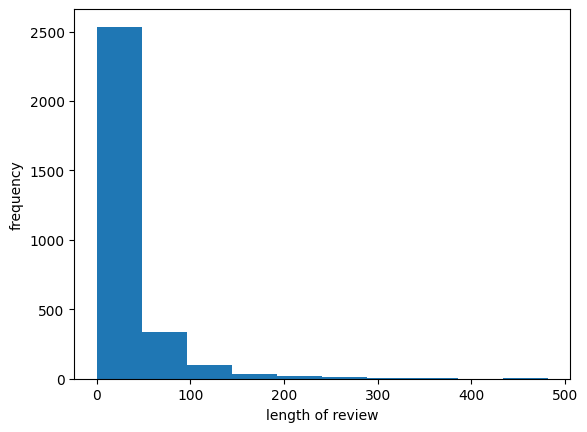

In [431]:
# 리뷰 길이 데이터의 분포 확인
import matplotlib.pyplot as plt
# hist그램의 y축은 빈도수
plt.hist(length)
plt.xlabel('length of review')
plt.ylabel('frequency')
plt.show()

In [455]:
# [1] 패딩을 위한 토큰 진행 (단어를 고유한 정수로 변환)
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['document'])
#print(tokenizer.word_index)
encoded = tokenizer.texts_to_sequences(x_train['document'])
#print(encoded)  
# 결과 : [[1], [33, 205, 422, 278],..., [1], [5, 10, .., 2, 205, 92]]

# 문장의 최대 길이
max_len = max(len(item) for item in encoded)
print('학습용 최대 길이 :',max_len)
# ---------------------------------------------
# 검증 데이터 토큰

tokenizer_val = Tokenizer()
tokenizer_val.fit_on_texts(x_val['document'])
encoded_val = tokenizer.texts_to_sequences(x_val['document'])
#print(encoded_val)

# 문장의 최대 길이
max_len_val = max(len(item) for item in encoded_val)
print('제출용 최대 길이 :',max_len_val)
# ---------------------------------------------
# 제출 데이터 토큰
tokenizer_submit = Tokenizer()
tokenizer_submit.fit_on_texts(processed_filtering_test_df['document'])
encoded_submit = tokenizer.texts_to_sequences(processed_filtering_test_df['document'])
#print(encoded_submit)

# 문장의 최대 길이
max_len_submit = max(len(item) for item in encoded_submit)
print('제출용 최대 길이 :',max_len_submit)

학습용 최대 길이 : 152
제출용 최대 길이 : 106
제출용 최대 길이 : 190


In [451]:
print(tokenizer.word_index)

{'좋다': 1, '하다': 2, '친절하다': 3, '최고': 4, '직원': 5, '있다': 6, '아쉬움': 7, '매장': 8, '없다': 9, '너무': 10, '사람': 11, '슬픔': 12, '많다': 13, '스타벅스': 14, '커피': 15, '넓다': 16, '스벅': 17, '가다': 18, '자리': 19, '맛': 20, '음료': 21, '곳': 22, '주문': 23, '층': 24, '별로': 25, '같다': 26, '되다': 27, '다': 28, '때': 29, '않다': 30, '좀': 31, '보다': 32, '불친절하다': 33, '여기': 34, '맛있다': 35, '오다': 36, '아쉽다': 37, '아니다': 38, '조금': 39, '이다': 40, '것': 41, '받다': 42, '화장실': 43, '해주다': 44, '먹다': 45, '파트너': 46, '다른': 47, '항상': 48, '들다': 49, '기분': 50, '분위기': 51, '그렇다': 52, '친절': 53, '나오다': 54, '말': 55, '자주': 56, '남자': 57, '손님': 58, '진짜': 59, '정말': 60, '서비스': 61, '자다': 62, '점': 63, '불친절': 64, '중': 65, '더': 66, '안': 67, '리저': 68, '주차': 69, '많이': 70, '지점': 71, '분': 72, '주다': 73, '안되다': 74, '브': 75, '공부': 76, '시끄럽다': 77, '조용하다': 78, '응대': 79, '제': 80, '엄청': 81, '여자': 82, '시키다': 83, '함': 84, '넘다': 85, '앉다': 86, '그냥': 87, '시간': 88, '일': 89, '크다': 90, '깨끗하다': 91, '알다': 92, '거': 93, '괜찮다': 94, '쾌적하다': 95, '이용': 96, '말다': 97, '테이블': 98, '당황': 99, '깔끔하다

In [449]:
len(tokenizer.word_index)

3708

In [457]:
# [2] 문장의 길이를 일정하게 조정 - pad_sequence()
# 문장의 최대 길이에 맞춰 모든 문장 길이 동일하게 만들기

from tensorflow.keras.preprocessing.sequence import pad_sequences

# maxlen : 해당 정수로 모든 문서의 길이를 동일하게 함
train_padded = pad_sequences(encoded, maxlen = max_len)
val_padded = pad_sequences(encoded_val, maxlen = max_len)
submit_padded = pad_sequences(encoded_submit, maxlen = max_len)
train_padded[25], val_padded[25], submit_padded[25]
# 학습용의 문장 최대 길이 : 152, 제출용 최대 길이 : 190 
# --> 제출용에 맞추면 최종 데이터도 학습을 시키는 것이기 때문에 
# => 학습용 문장 최대 길이에 맞춰 진행 필요

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [461]:
train_padded.shape, val_padded.shape

((3037, 152), (760, 152))

In [462]:
# input_dim : vocab size
# 참고 : https://wikidocs.net/44249
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합(vocabulary)의 크기 : 3708
등장 빈도가 2번 이하인 희귀 단어의 수: 2415
단어 집합에서 희귀 단어의 비율: 65.1294498381877
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 11.345181553546805
단어 집합의 크기 : 1294


In [469]:
# [3] RNN 순환층에 DropOut 적용하기 : lstm_dropout_RNN
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Embedding

# Embedding()
# input_dim : 학습용 총 단어의 개수
# output_dim : 결과로서 나오는 임베딩 벡터의 크기
# input_length : 입력 시퀀스의 길이

embedding_dim = 16 #100
hidden_units = 8#128

model_lstm_dropout = keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length = max_len),
    LSTM(hidden_units, dropout = 0.3),
    Dense(1, activation = 'sigmoid')
])

In [475]:
tf.__version__

'2.9.0'

In [477]:
# [4] 모델 학습
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)

model_lstm_dropout.compile(loss = 'binary_crossentropy', metrics = 'accuracy',
                           optimizer = rmsprop)

path = 'C:/playdata/Deep-Learning_basic/dataset/'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(path+'230302_saved_model/best-starbucks_lstm_dropout_RNN.h5',
                                                   save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3,
                                                  restore_best_weights = True)

hist = model_lstm_dropout.fit(train_padded, y_train, epochs = 10, batch_size = 64,
                              validation_data = (val_padded, y_val),
                    callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_3/embedding_3/embedding_lookup' defined at (most recent call last):
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Playdata\AppData\Local\Temp\ipykernel_480\2965433470.py", line 15, in <module>
      hist = model_lstm_dropout.fit(train_padded, y_train, epochs = 10, batch_size = 64,
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Playdata\Anaconda3\envs\tf2\lib\site-packages\keras\layers\core\embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_3/embedding_3/embedding_lookup'
indices[23,146] = 1778 is not in [0, 1294)
	 [[{{node sequential_3/embedding_3/embedding_lookup}}]] [Op:__inference_train_function_24457]

In [ ]:
model.save(path+'230302_saved_model/best-lstm_dropout_RNN.h5')

df = pd.DataFrame(hist.history)
print(max(df['val_accuracy']))

import matplotlib.pyplot as plt
plt.figure(figsize = (6, 6))
plt.plot(df.loss, label = 'train_loss')
plt.plot(df.val_loss, label = 'val_loss')
plt.legend()
plt.show()